In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import time

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import grid_utils
from code_utils import stats_utils, plot_utils, numpy_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 10
subjects = np.arange(1,11)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')

# this is the original analysis that I ran with 7 subjects, exactly as in first submission
save_filename1 = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
print(save_filename1)
print(time.ctime(os.path.getmtime(save_filename1)))
d1 = np.load(save_filename1, allow_pickle=True).item()

# this is the newest 3 subjects, for revision
save_filename2 = os.path.join(save_folder, 'decode_multiclass_withintask_newsubs.npy')
print(save_filename2)
print(time.ctime(os.path.getmtime(save_filename2)))
d2 = np.load(save_filename2, allow_pickle=True).item()
d2.keys()

# we're going to concatenate everything from these saved dictionaries
dec = dict([])
for kk in list(d1.keys()):
    
    if kk in ['preds_all', 'probs_all']:
        # this element is a dictionary where keys are subjects
        dec[kk] = d1[kk]
        for si in d2[kk].keys():
            # entry 0 in the new array becomes 7 in new array
            dec[kk][si+7] = d2[kk][si]
        
    elif kk in ['grid_pts', 'roi_names']:
        dec[kk] = d1[kk]
        
    else:
        dec[kk] = np.concatenate([d1[kk], d2[kk]], axis=0)
        
roi_names = dec['roi_names']
roi_names[-1] = 'IPS'
n_rois = len(roi_names)
roi_names

/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_multiclass_withintask.npy
Fri Jun  2 12:40:24 2023
/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_multiclass_withintask_newsubs.npy
Tue Aug 13 08:41:26 2024


['V1', 'V2', 'V3', 'V3AB', 'hV4', 'LO1', 'LO2', 'IPS']

#### Bin the data spatially to make heat-maps

In [6]:
sp = 0.1;
n_bins = 26;
bin_edges = np.linspace(-0.01, 5.01, n_bins+1)
bin_size = bin_edges[1]-bin_edges[0]
bin_centers = bin_edges[0:-1]+bin_size/2
bin_edges = bin_edges.round(2)
bin_centers = bin_centers.round(2)

n_bins = len(bin_centers)
bin_centers, bin_edges

(array([0.09, 0.28, 0.47, 0.67, 0.86, 1.05, 1.24, 1.44, 1.63, 1.82, 2.02,
        2.21, 2.4 , 2.6 , 2.79, 2.98, 3.18, 3.37, 3.56, 3.76, 3.95, 4.14,
        4.33, 4.53, 4.72, 4.91]),
 array([-0.01,  0.18,  0.38,  0.57,  0.76,  0.96,  1.15,  1.34,  1.53,
         1.73,  1.92,  2.11,  2.31,  2.5 ,  2.69,  2.89,  3.08,  3.27,
         3.47,  3.66,  3.85,  4.04,  4.24,  4.43,  4.62,  4.82,  5.01]))

In [7]:
n_axes = 3;
conf_binary_all = np.full(shape=(n_subjects, n_rois, n_tasks, n_axes, n_bins, n_bins), \
                         fill_value = np.nan)
bin_counts = np.full(shape=(n_subjects, n_tasks, n_bins, n_bins), \
                         fill_value = np.nan)

for si, ss in enumerate(subjects):

    # loop over tasks
    for ti, tt in enumerate([1,2,3,4]):
        
        # print(si,ti)
        
        l = lab[ss][lab[ss]['task']==tt]
        
        x = np.array(l['ptx'])
        y = np.array(l['pty'])
        
        used_yet = np.zeros(x.shape, dtype=bool)
        
        for bx in np.arange(n_bins):
            for by in np.arange(n_bins):
                
                pt_inds = (x>bin_edges[bx]) & (x<bin_edges[bx+1]) & (y>bin_edges[by]) & (y<bin_edges[by+1])
                bin_counts[si,ti,bx,by] = np.sum(pt_inds)
                if np.sum(pt_inds)==0:
                    continue
                assert(not np.any(used_yet[pt_inds]))
                used_yet[pt_inds] = True
                
                for ri in range(n_rois):

                    prob = dec['probs_all'][si][ri][ti]

                    # loop over "axes" - which boundary to compute accuracy for
                    for ii in range(n_axes):

                        # "confidence" in assignment to category 2 vs 1
                        # group the 16 points into categories w/r/t relevant axis
                        g1 = grid_utils.get_categ(grid_pts, ii+1)==1
                        p_categ1 = np.sum(prob[:,g1], axis=1)
                        g2 = grid_utils.get_categ(grid_pts, ii+1)==2
                        p_categ2 = np.sum(prob[:,g2], axis=1)

                        # signed confidence will be: p(correct) - p(incorrect)
                        signedconf = np.zeros_like(p_categ1)
                        categ_actual = l['categ_task%d'%(ii+1)]
            
                        signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                        signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]

                        pdiff = signedconf
                        # pdiff = p_categ2 - p_categ1
                        
                        # conf_binary_all[si,ri,ti,ii,bx,by] = np.mean(pdiff[pt_inds])
                        conf_binary_all[si,ri,ti,ii,bx,by] = np.sum(pdiff[pt_inds])
                    
        assert(np.all(used_yet))

In [8]:
conf_binary_all.shape

(10, 8, 4, 3, 26, 26)

In [9]:
# sum up the summed values over all subjects and divide by total count
# this is effectively like taking a mean of the concatenated trials over all subjects, but
# ignoring which trials came from which subject
all_sum = np.nansum(conf_binary_all, axis=0)
all_counts = np.sum(np.tile(bin_counts[:,None,:,None,:,:], [1,n_rois,1,n_axes,1,1]), axis=0)
all_mean = all_sum/all_counts
all_mean[all_counts==0] = np.nan

/usr/local/serenceslab/maggie/conda_envs/shape_dim/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [10]:
conf_binary_all[:,0,0,0,0,0]

array([ 3.8637065 ,  7.00288204,  6.53676058,  5.71925022, 10.64080454,
        6.96336084,  6.89884663, 13.89725114, 15.98984904, 18.35404775])

In [11]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/absval_class_conf_2d_axis1.pdf
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/absval_class_conf_2d_axis2.pdf


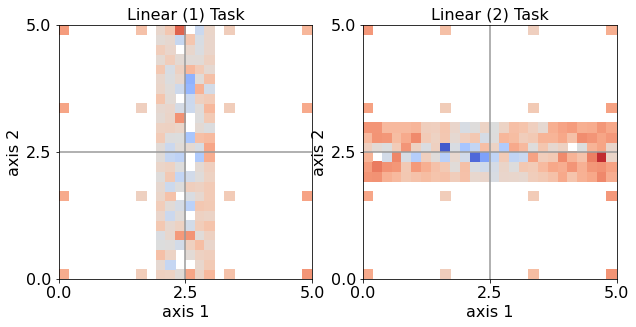

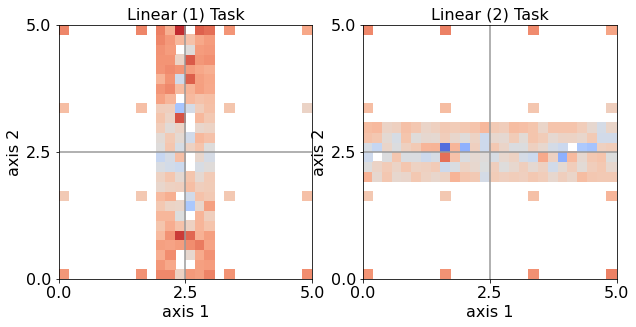

In [12]:
ri = 0;
# sub_avg = np.nanmean(conf_binary_all, axis=0)
sub_avg = all_mean

for ii, axis_name in enumerate(['Linear 1', 'Linear 2']):

    ticks_plot = np.array([0, int(n_bins/2), n_bins])
    # tickbins = np.arange(n_bins[)

    plt.figure(figsize=(10,5))
    
    for ti in range(2):
        vals = sub_avg[ri,ti,ii,:,:]

        # print(np.nanmin(vals.ravel()))
        # print(np.nanmax(vals.ravel()))
        ax = plt.subplot(1,2,ti+1)
        # vals[10,5] = 100
        plt.pcolormesh(vals.T, \
                       vmin=-1, vmax=1, \
                       # cmap = 'magma_r')
                       cmap='coolwarm')
        # ax.set_facecolor([0.8, 0.8, 0.8])
        plt.xlabel('axis 1')
        plt.ylabel('axis 2')
        # plt.xticks(np.arange(n_bins)+0.5,bin_centers)
        # plt.yticks(np.arange(n_bins)+0.5,bin_centers)
        # plt.xticks(np.arange(n_bins+1),bin_edges)
        # plt.yticks(np.arange(n_bins+1),bin_edges)
        plt.xticks(ticks_plot, np.abs(np.array(bin_edges)[ticks_plot].round(1)))
        plt.yticks(ticks_plot, np.abs(np.array(bin_edges)[ticks_plot].round(1)))
        plt.title('%s Task'%task_names[ti] )

        plt.axhline(n_bins/2, color=[0.6, 0.6, 0.6])
        plt.axvline(n_bins/2, color=[0.6, 0.6, 0.6])
        plt.axis('square')
        
        # plt.colorbar()

    # plt.suptitle('%s\n%s: p(category 2) - p(category 1)'%(roi_names[ri], axis_name ))
    
    figname = os.path.join(figfolder, 'absval_class_conf_2d_axis%d.pdf'%(ii+1))
    print(figname)
    plt.savefig(figname)